In [3]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns
import pycountry as pc

In [7]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores
def analysis(uni19_df):
    uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
    uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
    uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
    nodes = np.array(list(set.union(set(uni19_df.loc[:, 'Sending Organization' ]), set(uni19_df.loc[:, 'Receiving Organization']))))
    uni19_df.dropna(how='any', inplace=True)
    # I don't want it to take forever
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    uni19_df['SendId'] = (np.array(list(map(lambda x: node_position[x], uni19_df['Sending Organization']))))
    uni19_df['RecId']= (np.array(list(map(lambda x: node_position[x], uni19_df['Receiving Organization']))))
    # Adjacency matrix
    country_serie = uni19_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
    row = np.array(country_serie.index.get_level_values(1).tolist())
    col = np.array(country_serie.index.get_level_values(0).tolist())
    val = country_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))


    ns.visualize_adj(adj_matrix_crs)
    matr = adj_matrix_crs.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    uni19_df.rename({'Sending Organization': 'source', 'Receiving Organization':'target', 'Participants':'weight'},axis=1, inplace=True)
    components = ns.find_components(adj_matrix_crs, nodes_df)
    unique, counts = np.unique(components['component'], return_counts=True)
    print('Number of components =', len(unique))
    scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
    ns.display_top_n(scores, 10, 'in degree')
    ns.display_top_n(scores, 10, 'out degree')
    df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')
    ns.display_top_n(scores, 10, 'hits hub')
    ns.display_top_n(scores, 10, 'hits autority')
    df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')

    ns.display_top_n(scores, 10, 'PageRank hub')
    ns.display_top_n(scores, 10, 'PageRank autority')

    sns.pairplot(scores)
    plt.show()
    scores = create_position(scores, 'in degree')
    scores = create_position(scores, 'out degree')
    scores = create_position(scores, 'hits hub')
    scores = create_position(scores, 'hits autority')
    scores = create_position(scores, 'PageRank hub')
    scores = create_position(scores, 'PageRank autority')
    scores.sort_index(inplace=True)
    n = 40
    pd.set_option('display.max_rows', n)
    display(scores.sort_values('PageRank autority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank autority', 'PageRank autority position']].head(n))
    display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))
    edges = uni19_df[['source','target']].copy()
    print(ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True))
    # label = 'PageRank autority position'
    label = 'in degree position'
    c = uni19_df.drop(['SendId', 'RecId'],axis=1)
    another_order = scores[['Nodes', label]].copy()
    another_order[label] = another_order[label] - 1
    another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="source")
    another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="target")
    c = c[['source ID', 'target ID', 'weight']]
    c_serie = c.groupby(['source ID', 'target ID']).sum()
    row = np.array(c_serie.index.get_level_values(1).tolist())
    col = np.array(c_serie.index.get_level_values(0).tolist())
    val = c_serie.values
    or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    ns.visualize_adj(or_adj)
    matr = or_adj.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()

In [2]:
def replace_iso3166(alpha):
        try:
            return pc.countries.get(alpha_2=alpha).name
        except:
            return alpha

In [101]:
uni19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
city_df = pd.read_csv('data\worldcities.csv', sep=',', low_memory=False, header=0, encoding= 'utf8')
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
uni19_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), uni19_df['Receiving Country Code']))))
uni19_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), uni19_df['Sending Country Code']))))
mob_df = uni19_df.rename(columns={'Sending Organization': 'Source','Receiving Organization': 'Target', 'Participants':'weight', 'Sending Country Code': 'country'})
node_df = mob_df.iloc[:, [15,17]].drop_duplicates(subset='Source')
labels = list(range(0,4339))
node_df['source'] = labels
mob = mob_df.rename(columns={'Source': 'Target'})
node_df1 = mob.iloc[:, [15,17]].drop_duplicates(subset='Target')
node_df1["target"] = labels
results = pd.merge(mob_df,node_df, how='inner', on='Source')
results = pd.merge(results, node_df1, how='inner', on='Target')
edges_df = results.iloc[:, [27,25,23]].groupby(['source','target']).sum()
edges_df.to_csv('edges_universities1.csv')
node = pd.DataFrame()
node['Source'] = mob_df['Source'].unique()
nodes = mob_df.iloc[:, [15,16,17]].drop_duplicates(subset='Source')
#nodes = pd.merge(node,node1,how='left',on='Source').drop_duplicates(subset='Source')
city_df.rename(columns={'city_ascii':'Sending City'}, inplace=True)
city_df['Sending City'] = city_df['Sending City'].str.lower()
nodes['Sending City'] = nodes['Sending City'].str.lower()
city_df = city_df.iloc[:,[1,2,3,7]]
nodes2 = pd.merge(nodes,city_df,how='left',on='Sending City')
nodes2.drop_duplicates(subset='Source', inplace=True)
nodes2['id'] = labels
nodes2.to_csv('nodes_universities1.csv')
nodes2

,country,Sending City,Source,lat,lng,admin_name,id
0,China,beijing,China Foreign Affairs University,39.9050,116.3914,Beijing,0
1,Austria,wien,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,48.2083,16.3731,Wien,1
2,Russian Federation,rostov on don,SOUTHERN FEDERAL UNIVERSITY,NaN,NaN,NaN,2
3,Russian Federation,saint petersburg,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,59.9500,30.3167,Sankt-Peterburg,3
4,Austria,wien,UNIVERSITAT WIEN,48.2083,16.3731,Wien,4
...,...,...,...,...,...,...,...
6185,UK,dunbeg oban,THE SCOTTISH ASSOCIATION FOR MARINESCIENCE LBG,NaN,NaN,NaN,4334
6186,UK,london,BIRKBECK COLLEGE - UNIVERSITY OF LONDON,51.5072,-0.1275,"London, City of",4335
6190,UK,london,IMPERIAL COLLEGE OF SCIENCE TECHNOLOGY AND MED...,51.5072,-0.1275,"London, City of",4336
6194,UK,london,REGENT'S UNIVERSITY LONDON LIMITED,51.5072,-0.1275,"London, City of",4337


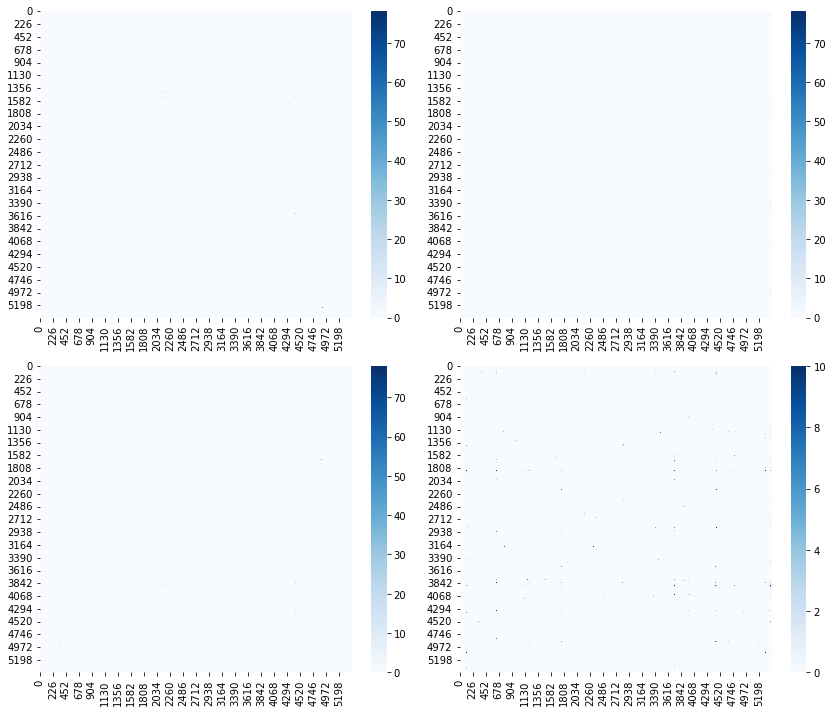

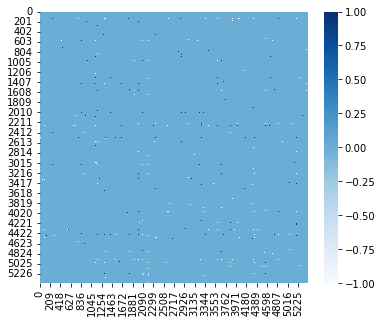

Number of components = 17


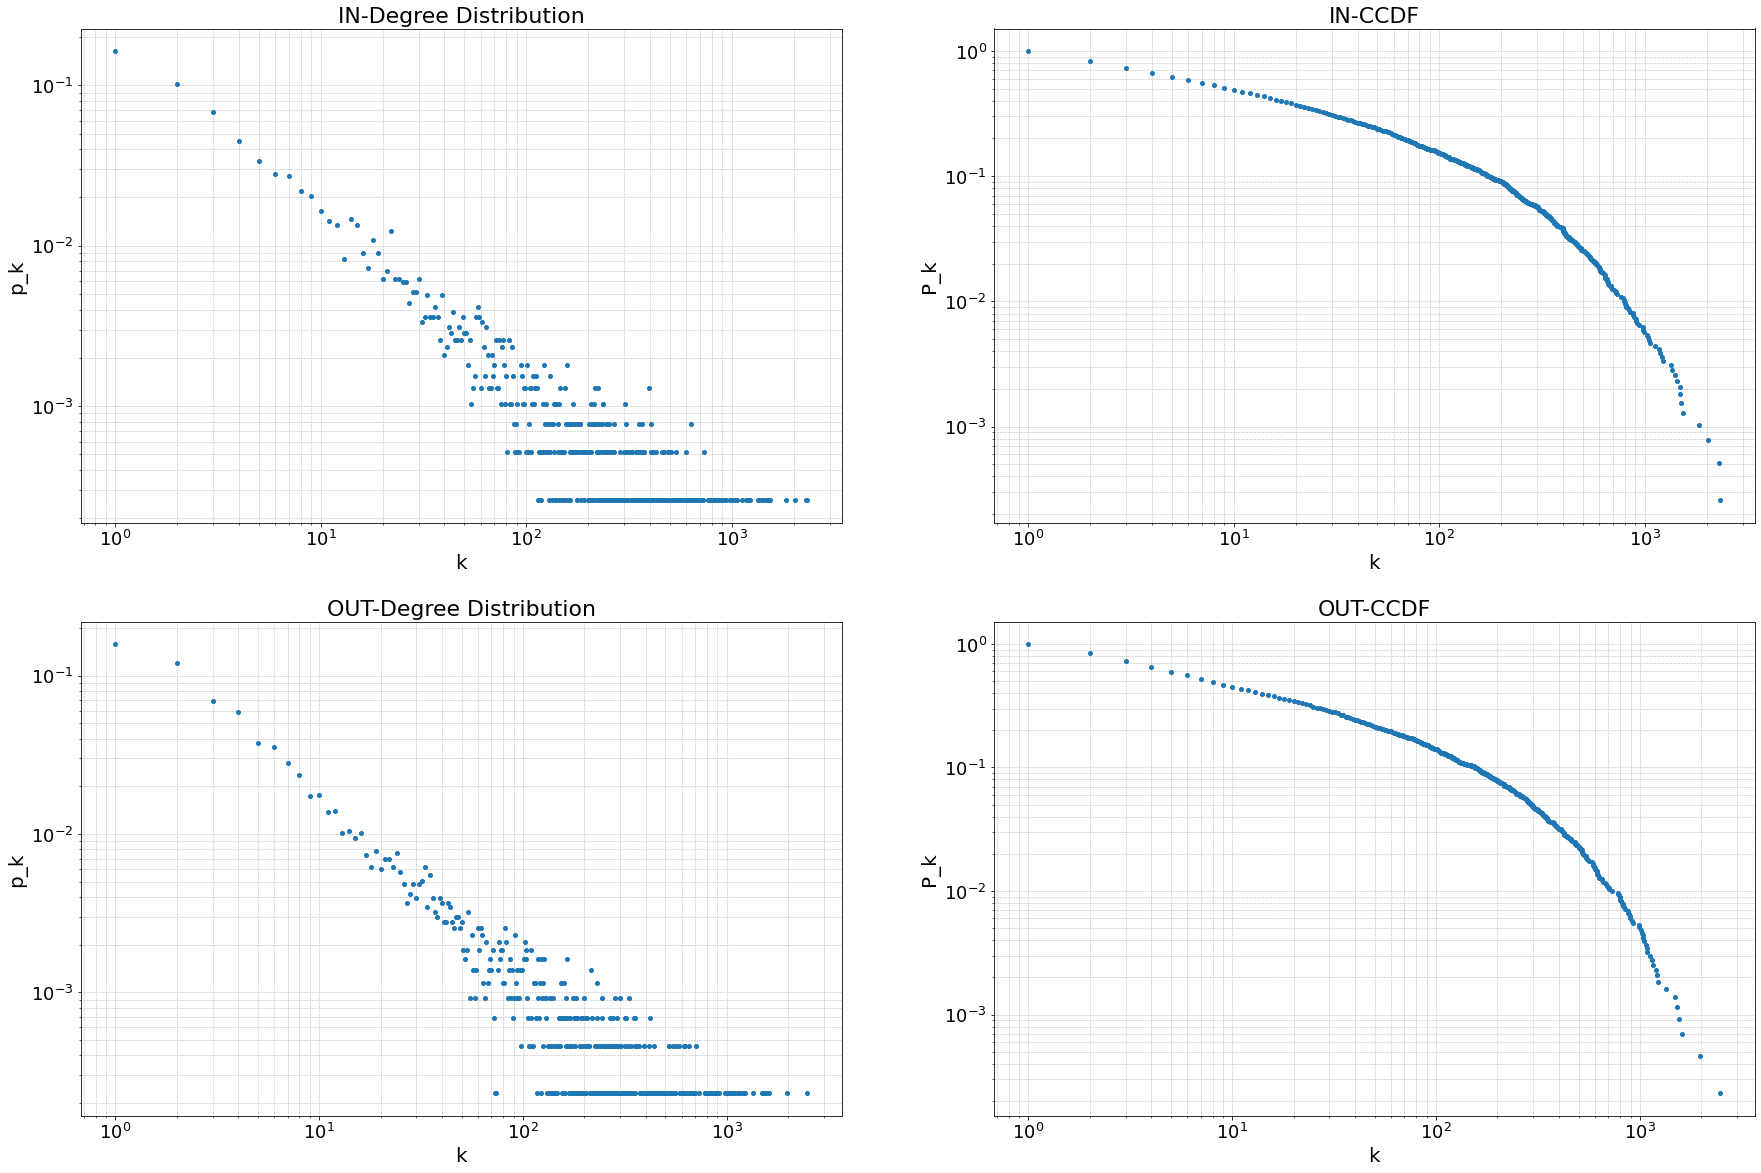

Top 10 for in degree


,Nodes,in degree
646,UNIVERSITAT DE VALENCIA,2329
4439,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2297
3224,UNIVERSIDADE DE LISBOA,2039
4256,UNIVERSIDAD DE GRANADA,1832
1530,UNIVERSIDAD COMPLUTENSE DE MADRID,1535
4302,UNIVERZA V LJUBLJANI,1507
5397,UNIVERSITAT POLITECNICA DE VALENCIA,1489
2176,UNIVERZITA KARLOVA,1484
2400,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1433
2131,KATHOLIEKE UNIVERSITEIT LEUVEN,1408


Top 10 for out degree


,Nodes,out degree
4439,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2478
4256,UNIVERSIDAD DE GRANADA,1970
646,UNIVERSITAT DE VALENCIA,1614
2960,UNIVERSITA DEGLI STUDI DI PADOVA,1556
1530,UNIVERSIDAD COMPLUTENSE DE MADRID,1518
2271,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1490
4055,UNIVERSITA DEGLI STUDI DI TORINO,1349
5205,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1230
5310,POLITECNICO DI MILANO,1214
3731,UNIVERSIDAD DE SEVILLA,1198


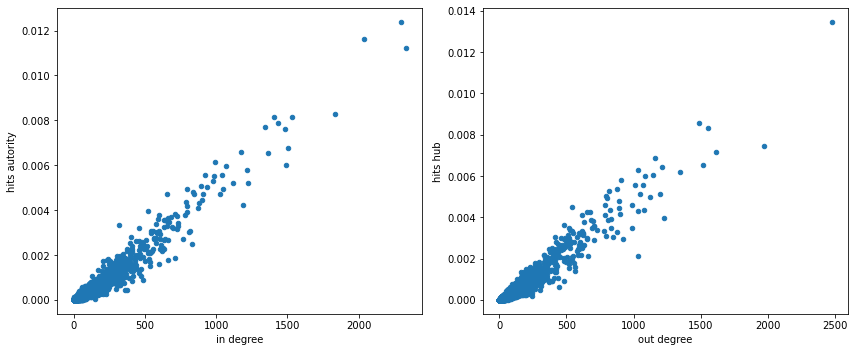

Top 10 for hits hub


,Nodes,hits hub
4439,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013433
2271,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.008579
2960,UNIVERSITA DEGLI STUDI DI PADOVA,0.008316
4256,UNIVERSIDAD DE GRANADA,0.007472
646,UNIVERSITAT DE VALENCIA,0.007149
3224,UNIVERSIDADE DE LISBOA,0.006850
1530,UNIVERSIDAD COMPLUTENSE DE MADRID,0.006546
5310,POLITECNICO DI MILANO,0.006413
121,TECHNISCHE UNIVERSITAET MUENCHEN,0.006302
4055,UNIVERSITA DEGLI STUDI DI TORINO,0.006184


Top 10 for hits autority


,Nodes,hits autority
4439,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.012363
3224,UNIVERSIDADE DE LISBOA,0.011628
646,UNIVERSITAT DE VALENCIA,0.011203
4256,UNIVERSIDAD DE GRANADA,0.008268
1530,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008167
2131,KATHOLIEKE UNIVERSITEIT LEUVEN,0.008154
2400,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.007880
3731,UNIVERSIDAD DE SEVILLA,0.007694
2176,UNIVERZITA KARLOVA,0.007619
4302,UNIVERZA V LJUBLJANI,0.006769


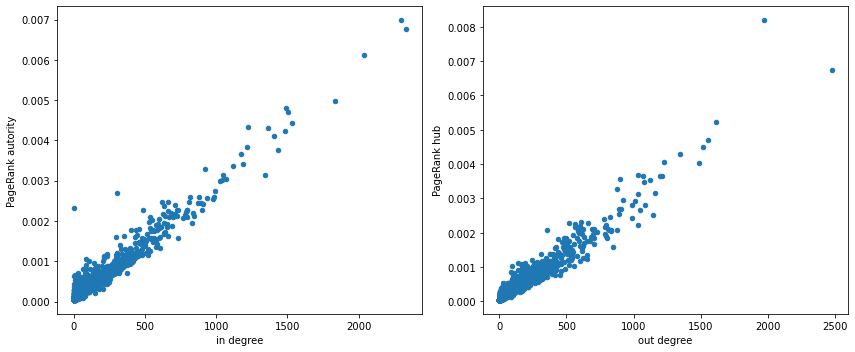

Top 10 for PageRank hub


,Nodes,PageRank hub
4256,UNIVERSIDAD DE GRANADA,0.008190
4439,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006736
646,UNIVERSITAT DE VALENCIA,0.005238
2960,UNIVERSITA DEGLI STUDI DI PADOVA,0.004704
1530,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004486
4055,UNIVERSITA DEGLI STUDI DI TORINO,0.004291
5205,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,0.004049
2271,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004037
3495,UNIVERSIDAD REY JUAN CARLOS,0.003677
5310,POLITECNICO DI MILANO,0.003665


Top 10 for PageRank autority


,Nodes,PageRank autority
4439,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006979
646,UNIVERSITAT DE VALENCIA,0.006764
3224,UNIVERSIDADE DE LISBOA,0.006112
4256,UNIVERSIDAD DE GRANADA,0.004989
5397,UNIVERSITAT POLITECNICA DE VALENCIA,0.004809
4302,UNIVERZA V LJUBLJANI,0.004715
1530,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004434
5310,POLITECNICO DI MILANO,0.004339
2271,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004312
2176,UNIVERZITA KARLOVA,0.004221


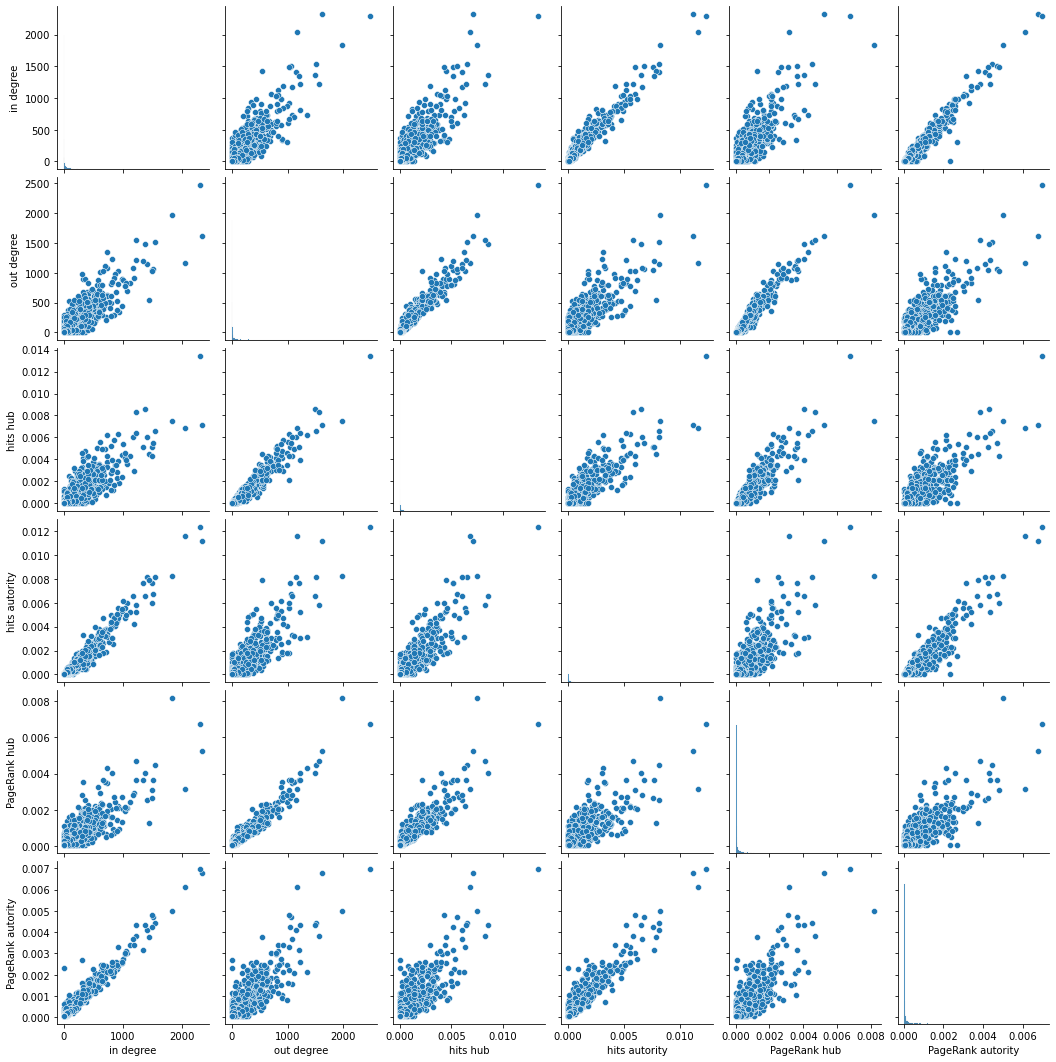

,Nodes,in degree,in degree position,hits autority,hits autority position,PageRank autority,PageRank autority position
4439,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2297,2,0.012363,1,0.006979,1
646,UNIVERSITAT DE VALENCIA,2329,1,0.011203,3,0.006764,2
3224,UNIVERSIDADE DE LISBOA,2039,3,0.011628,2,0.006112,3
4256,UNIVERSIDAD DE GRANADA,1832,4,0.008268,4,0.004989,4
5397,UNIVERSITAT POLITECNICA DE VALENCIA,1489,7,0.006006,14,0.004809,5
4302,UNIVERZA V LJUBLJANI,1507,6,0.006769,10,0.004715,6
1530,UNIVERSIDAD COMPLUTENSE DE MADRID,1535,5,0.008167,5,0.004434,7
5310,POLITECNICO DI MILANO,1222,13,0.005205,22,0.004339,8
2271,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1363,11,0.006562,12,0.004312,9
2176,UNIVERZITA KARLOVA,1484,8,0.007619,9,0.004221,10


,Nodes,out degree,out degree position,hits hub,hits hub position,PageRank hub,PageRank hub position
4256,UNIVERSIDAD DE GRANADA,1970,2,0.007472,4,0.008190,1
4439,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2478,1,0.013433,1,0.006736,2
646,UNIVERSITAT DE VALENCIA,1614,3,0.007149,5,0.005238,3
2960,UNIVERSITA DEGLI STUDI DI PADOVA,1556,4,0.008316,3,0.004704,4
1530,UNIVERSIDAD COMPLUTENSE DE MADRID,1518,5,0.006546,7,0.004486,5
4055,UNIVERSITA DEGLI STUDI DI TORINO,1349,7,0.006184,10,0.004291,6
5205,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1230,8,0.003941,36,0.004049,7
2271,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1490,6,0.008579,2,0.004037,8
3495,UNIVERSIDAD REY JUAN CARLOS,1032,18,0.002142,117,0.003677,9
5310,POLITECNICO DI MILANO,1214,9,0.006413,8,0.003665,10


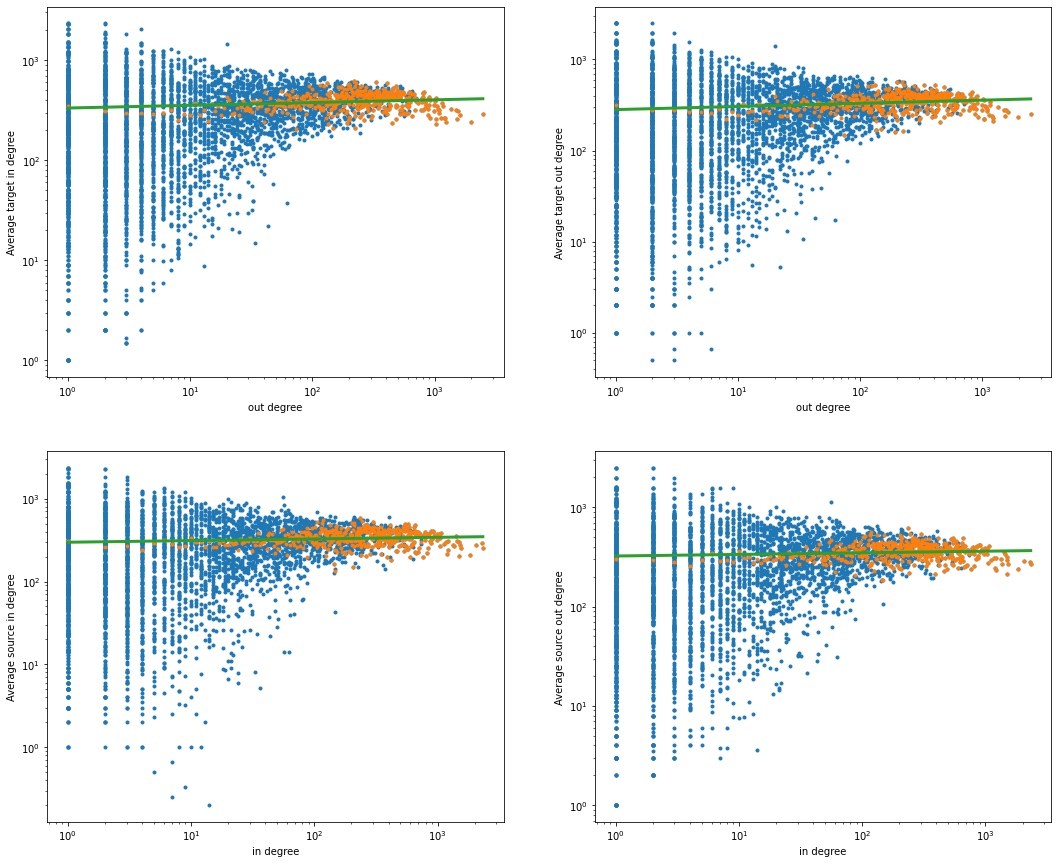

(0.02739359565730594, 0.03452761050631411, 0.019834649141170776, 0.01613843714338196)


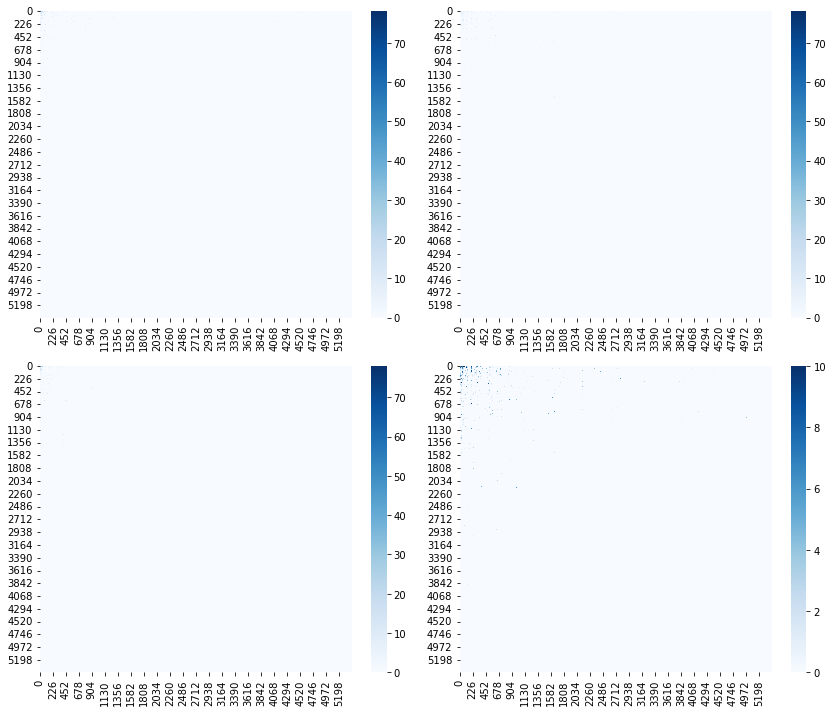

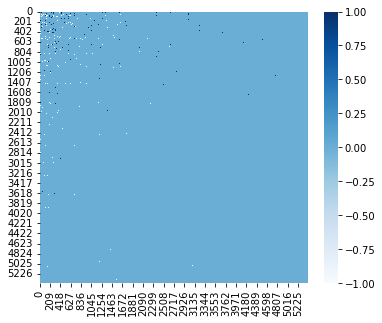

In [5]:
uni19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(uni19_df)